Относительная погрешность
0.431092980778 %

Максимальная абсолютная погрешность
4.36058910721


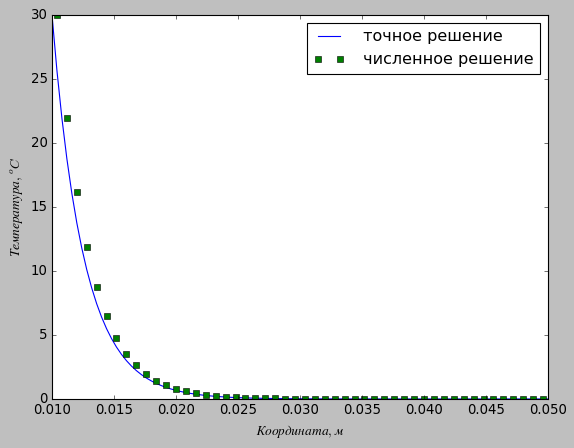

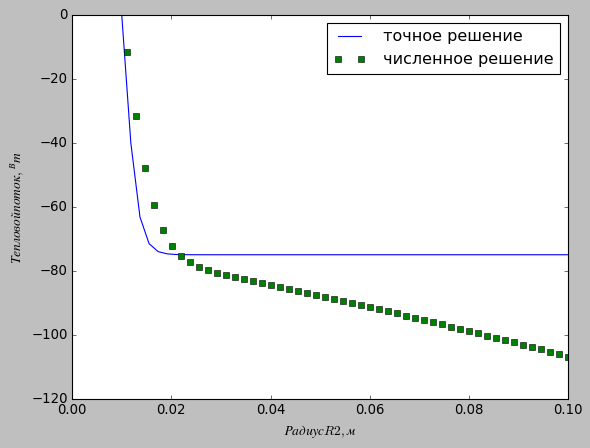

In [44]:
%matplotlib inline
import math
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

#Параметры

N = 6 # Номер бригады
R1 = 10*10**(-3) #Внутренний радиус кольца м
R2 = 50*10**(-3) #Внешний радиус кольца м
Lx = R2-R1 #длина расчетной области м
delta = 0.1*(N+4)*10**(-3) #Толщина м
Bi_value = N/100 #Число Био
m_value = ((2*Bi_value)**0.5)/delta #Число m
Theta_0 = 5*N #Разность температур *C
Lambda = 101 #коэфф теплоп-ти Вт/м*К
T_liquid = 0 #*C
Qv = 0
#Tg_R1 = 30.0 #температура  жидкости слева
#Tg_R2 = 55.0 #температура жидкости справа

#Alph_R1 = 100 #коэфф теплотдачи на границе слева
#Alph_R2 = 1000 #коэфф теплотдачи на границе справа

#####################################################################################################################
i = 0  #Определитель количества контрольных объемов
#####################################################################################################################

# Массив объемов
Nv=[50,10,30,100,200,300,500,600,800,1000,5000]

def Integrate(Y,X):
    Integral = 0
    for i in range(np.size(X)-1):
        Integral += (Y[i+1]+Y[i])*(X[i+1]-X[i])/2
    return(Integral)

def fun_T_XP_math(R2,Nx,R1,delta,Lambda,Bi_value,Theta_0,T_liquid):
    # Длина каждого контрольного, применительно для ребра есть разность радиусов 
    dx = (R2-R1)/Nx
    #print("Длина каждого контрольного объема:")
    #print(dx)
    #print()
    #Радиусы граней
    XFace = np.linspace(R1,R2,Nx+1)
    #print("Радиусы граней")
    #print(XFace)
    #print("")

    #Площади граней
    AFace = np.zeros(Nx+1)
    for j in range(Nx+1):
        AFace[j] = 2*math.pi*(R1 + dx*j)*delta
    #print("Площади граней")
    #print(AFace)
    #print("")

    #Средние сечения контрольных объемов
    XP = np.zeros(Nx)
    for j in range(Nx):
        XP[j] = (XFace[j] + XFace[j+1])/2.0
    #print("Центры контрольных объемов")
    #print(XP)
    #print("")

    #Объёмы контрольных объемов -_- 
    VolumP = np.zeros(Nx) 
    for j in range(Nx):
        VolumP[j] = math.pi*(XFace[j+1]**2-XFace[j]**2)*delta
    #print("Контрольные объемы контрольных объемов -_-")
    #print(VolumP)
    #print("")

    #Численное решение
    Vector_b = np.zeros(Nx)
    Matrix_A = np.zeros((Nx,Nx))

    Vector_b[0] = Theta_0 + T_liquid
    
    for j in range(1,Nx-1):
        Matrix_A[j][j-1] = 2.0*math.pi*delta*Lambda*XP[j]/(dx**2)
        Matrix_A[j][j] = -2.0*math.pi*delta*Lambda*(1+2*XP[j]/dx)/dx - 4*math.pi*XP[j]*Bi_value*Lambda/delta
        Matrix_A[j][j+1] = 2.0*math.pi*delta*Lambda*(1+XP[j]/dx)/dx
        Vector_b[j] = -4.0*math.pi*Bi_value*Lambda*XP[j]*T_liquid/delta
    Matrix_A[0][0] = 1
    Matrix_A[Nx-1][Nx-1] = 1
    Matrix_A[Nx-1][Nx-2] = -1
    #print("Правая часть матрицы:")
    #print(Vector_b)
    #print("")
    #print("Матрица уравнений")
    #print(Matrix_A)
    #print("")

    Theta_math = np.linalg.solve(Matrix_A,Vector_b)
    return(Theta_math,XP)

def fun_T_Volume_math(R2,Nx,R1,delta,Lambda,Bi_value,Theta_0,T_liquid,Qv):
    # Длина каждого контрольного, применительно для ребра есть разность радиусов 
    dx = (R2-R1)/Nx
    #print("Длина каждого контрольного объема:")
    #print(dx)
    #print()
    #Радиусы граней
    XFace = np.linspace(R1,R2,Nx+1)
    #print("Радиусы граней")
    #print(XFace)
    #print("")

    #Площади граней
    AFace = np.zeros(Nx+1)
    for j in range(Nx+1):
        AFace[j] = 2*math.pi*(R1 + dx*j)*delta
    #print("Площади граней")
    #print(AFace)
    #print("")

    #Средние сечения контрольных объемов
    XP = np.zeros(Nx)
    for j in range(Nx):
        XP[j] = (XFace[j] + XFace[j+1])/2.0
    #print("Центры контрольных объемов")
    #print(XP)
    #print("")

    #Объёмы контрольных объемов -_- 
    VolumP = np.zeros(Nx) 
    for j in range(Nx):
        VolumP[j] = math.pi*(XFace[j+1]**2-XFace[j]**2)*delta
    #print("Контрольные объемы контрольных объемов -_-")
    #print(VolumP)
    #print("")
    
    #Массив с обобщённым коэфф диффузии в центрах контрольных объемов
    Gamma = np.zeros(Nx)
    Gamma[:] = Lambda

    #расчет коэфф проводимости для каждой ячейки
    Alpha = np.zeros(Nx,dtype=float)
    Alpha = 2.0*Gamma/dx

    #Связь P и W  
    AW = np.zeros(Nx,dtype=float)
    AW[1:Nx] = 1.0/(1.0/Alpha[0:Nx-1]+1.0/Alpha[1:Nx])*AFace[1:Nx]

    #связь Р и Е  
    AE = np.zeros(Nx,dtype=float)
    AE[0:Nx-1] = 1.0/(1.0/Alpha[0:Nx-1]+1.0/Alpha[1:Nx])*AFace[1:Nx]

    #Задание постоянного источника при помощи "коэфф" и "значения" -
    CSource = np.zeros(Nx,dtype=float)
    CSource[:] = 2*Bi_value*Lambda/(delta**2) #10**7
    VSource = np.zeros(Nx,dtype=float)
    VSource[:] = T_liquid ##

    #создаём массив АР
    AP = np.zeros(Nx,dtype=float)
    #заполняем массив АР
    AP = AW + AE + CSource*VolumP

    #создаём массив В 
    b = np.zeros(Nx,dtype=float)
    b = CSource*VSource*VolumP

    #левая и правая границы
    AP[0] += Alpha[0]*AFace[0] 
    AP[Nx-1] += (Alpha[Nx-1])*AFace[Nx]

    #левая и правая границы
    #b[0] = Alpha[0]*AFace[0]*(Theta_0+T_liquid)
    b[0] = Theta_0+T_liquid
    b[Nx-1] = (Bi_value*Lambda/delta)*AFace[Nx]*T_liquid
    #b[Nx-1] = T_liquid

    A = np.zeros((Nx,Nx),dtype=float)
    #перебираем внутренние КО (с нуля) 
    for j in range(1,Nx-1):
        A[j,j-1] = -AW[j] #коэфф aw
        A[j,j+1] = -AE[j] #коэфф ae
        A[j,j] = AP[j] #коэфф аp
    #A[0,0] = AP[0]
    #A[0,1] = -AE[0]
    A[(Nx-1),(Nx-1)] = AP[Nx-1]
    A[Nx-1,Nx-2] = -AW[Nx-1]
    A[0,0] = 1
    A[0,1] = -0
    #A[(Nx-1),(Nx-1)] = 1
    #A[Nx-1,Nx-2] = -0
    #print(A)
    Phi = np.linalg.solve(A,b)
    #print("A =",A[0][0]," ",A[0][1]," ",A[0][2]," B=",b[0])
    #print("T =",Phi[0]," ",Phi[1]," ",Phi[2])

    T = Phi #возвращаемся к физ. обозачениям
    #T
    Q= np.zeros(Nx)
    Q[:] = VolumP[:]*CSource[:]*T
    Q_sum = np.sum(Q)
    return(T,XP,Q_sum)


Theta_math = np.zeros(Nv[i])
XP = np.zeros(Nv[i])
Theta_math,XP,Q_x = fun_T_Volume_math(R2,Nv[i],R1,delta,Lambda,Bi_value,Theta_0,T_liquid,0)

#Точное решение для температуры
def fun_T_exact(x,TfA,mval,R1,R2):
    from scipy import special
    retVal = TfA
    retVal *= (special.i0(mval*x)*special.k1(mval*R2)+special.i1(mval*R2)*special.k0(mval*x))
    retVal /=(special.i0(mval*R1)*special.k1(mval*R2)+special.i1(mval*R2)*special.k0(mval*R1))
    return retVal

X_exact = np.linspace(R1,R2,101)
T_exact = fun_T_exact(X_exact,Theta_0,m_value,R1,R2)
T_N_exact = fun_T_exact(XP,Theta_0,m_value,R1,R2)

#Учет погрешности

#print("Численное решение")
#print(Theta_math)
#print("")
#print("Аналитическое решение в соответствующих контрольных объемах")
#print(T_N_exact)
#print("")

d_epsilon = 0
for j in range(Nv[i]):
    d_epsilon += (Theta_math[j]-T_N_exact[j])**2
d_epsilon = (d_epsilon**0.5)/(Nv[i]*Theta_0)*100
epsilon = np.abs(Theta_math-T_N_exact)

print("Относительная погрешность")
print(d_epsilon,"%")
print("")
print("Максимальная абсолютная погрешность")
print(np.max(epsilon))

#Графики температур
plt.plot(X_exact,T_exact,label=' точное решение')
plt.plot(XP,Theta_math,'s',label=' численное решение') 
plt.legend()
plt.xlabel("$Координата, м$")
plt.ylabel("$Температура, ^oC$")
plt.show()

#Численное решение теплового потока
def fun_Q_math(R_2_x,N,R1,delta,Theta_0,T_liquid,Bi,Lambda,Qv,fun_T_Volume_math,Integrate):
    T,XP,Q = fun_T_Volume_math(R_2_x,N,R1,delta,Lambda,Bi,Theta_0,T_liquid,Qv)
    return(-Q)

Nx = 50

R_2_x_math = np.linspace(R1+0.001,2.0*R2,Nx)
#print(R_2_x)
Q_math = np.zeros(np.size(R_2_x_math))
Q_inter = np.zeros(np.size(Q_math))
for i in range(np.size(R_2_x_math)):
    Q_math[i] = fun_Q_math(R_2_x_math[i],Nx,R1,delta,Theta_0,T_liquid,Bi_value,Lambda,0,fun_T_Volume_math,Integrate)
    #Q_inter[i] = Q_math[i]/( Bi_value*Lambda*(delta**-1)*4*math.pi)
#print(Q_math)
#print(Q_inter)


#Точное решение теплового потока
def fun_Q_R2(R2,R1,m_value,delta,Theta_0,Lambda):
    from scipy import special
    Q = 2*math.pi*R1*Theta_0*delta*m_value*Lambda
    Q *=special.i1(m_value*R1)*special.k1(m_value*R2) - special.i1(m_value*R2)*special.k1(m_value*R1)
    Q /=special.i0(m_value*R1)*special.k1(m_value*R2) + special.i1(m_value*R2)*special.k0(m_value*R1)
    return Q

#График теплового потока
Number_Q_exact = 100
R_2_exact = np.linspace(R1,2.0*R2)
    
plt.plot(R_2_exact,fun_Q_R2(R_2_exact,R1,m_value,delta,Theta_0,Lambda),label=' точное решение')
plt.plot(R_2_x_math,Q_math,'s',label=' численное решение') 
plt.legend()
plt.xlabel("$Радиус R2, м$")
plt.ylabel("$Тепловой поток, ^Вт$")
plt.show()    
 